## Part 1: Introduction to CAPSA

As we saw in lecture 6, it is critical to be able to estimate bias and uncertainty robustly: we need benchmarks that uniformly measure how uncertain a given model is, and we need principled ways of measuring bias and uncertainty. To that end, in this lab, we'll utilize [CAPSA](https://github.com/themis-ai/capsa), a risk-estimation wrapping library developed by [Themis AI](https://themisai.io/). CAPSA supports the estimation of three different types of *risk*, defined as measures of how trustworthy our model is. These are:
1. Representation bias: using a histogram estimation approach, CAPSA calculates how likely combinations of features are to appear in a given dataset. Often, certain combinations of features are severely underrepresented in datasets, which means models learn them less well. Since evaluation metrics are often also biased in the same manner, these biases are not caught through traditional validation pipelines.
2. Aleatoric uncertainty: we can estimate the uncertainty in *data* by learning a layer that predicts a standard deviation for every input. This is useful to determine when sensors have noise, classes in datasets have low separations, and generally when very similar inputs lead to drastically different outputs.
3. Epistemic uncertainty: also known as predictive or model uncertainty, epistemic uncertainty captures the areas of our underlying data distribution that the model has not yet learned. Areas of high epistemic uncertainty can be due to out of distribution (OOD) samples or data that is harder to learn.


The core ideology behind CAPSA is that models can be *wrapped* in a way that makes them *risk-aware*. This means that CAPSA augments or modifies the user's original model minimally to create a risk-aware variant while preserving the model's underlying structure and training pipeline. CAPSA is a one-line addition to any training workflow in Tensorflow. In this part of the lab, we'll apply CAPSA's risk estimation methods to a toy regression task to further explore the notions of bias and uncertainty. 

Let's first install necessary dependencies:

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
!pip install capsa

from capsa import *
from helper import gen_data_regression

!pip install mitdeeplearning
import mitdeeplearning as mdl
import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115441 sha256=01749b67e04a95830862031f58fadf8cc175b09bcbbaac1d6cb3d7416d532e9c
  Stored in directory: /root/.cache/pip/wheels/2e/45/44/c5b304f31f37e8d2315f9e969fd8cdb0014a5c28608d0bf410
Successfully built mitdeeplearning


### 1.1 Datasets 
Next, let's construct a dataset that we'll analyze. As shown in lecture, we'll look at the curve `y = x^3` with epistemic and aleatoric noise added to certain parts of the dataset. The blue points below are the test data: note that there are regions where we have no train data but we have test data! Do you expect these areas to have higher or lower uncertainty? What type of uncertainty?

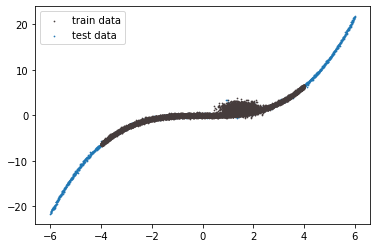

In [22]:
x, y, x_val, y_val = gen_data_regression(32)

### 1.2 Vanilla regression
Let's define a small model that can predict `y` given `x`: this is a classical regression task!

In [30]:
def create_standard_classifier():
  return tf.keras.Sequential(
          [
              tf.keras.Input(shape=(1,)),
              tf.keras.layers.Dense(8, "relu"),
              tf.keras.layers.Dense(8, "relu"),
              tf.keras.layers.Dense(1),
          ]
  )

standard_classifier = create_standard_classifier()

Let's first train this model normally, without any wrapping. Which areas would you expect the model to do well in? Which areas should it do worse in?

In [31]:
standard_classifier.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
  loss=tf.keras.losses.MeanSquaredError(),
)

history = standard_classifier.fit(x, y, epochs=10)


Epoch 1/10
640/640 [==============================] - 1s 2ms/step - loss: 1.0985
Epoch 2/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3952
Epoch 3/10
640/640 [==============================] - 1s 2ms/step - loss: 0.3380
Epoch 4/10
640/640 [==============================] - 1s 1ms/step - loss: 0.3137
Epoch 5/10
640/640 [==============================] - 1s 1ms/step - loss: 0.2867
Epoch 6/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2580
Epoch 7/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2393
Epoch 8/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2281
Epoch 9/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2216
Epoch 10/10
640/640 [==============================] - 1s 2ms/step - loss: 0.2177


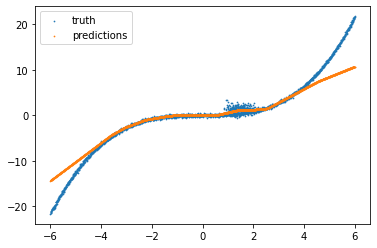

In [36]:
plt.scatter(x_val, y_val, s=0.5, label='truth')
plt.scatter(x_val, standard_classifier(x_val), s=0.5, label='predictions')
plt.legend()

### 1.3 Bias Identification
Now that we've seen what the predictions from this model look like, let's see what the uncertainty and bias look like! To do this, we'll wrap a model first with a `HistogramWrapper`. For low-dimensional data, the HistogramWrapper bins the input directly into discrete categories and measures the density. 

In [79]:
standard_classifier = create_standard_classifier()
bias_wrapped_classifier = HistogramWrapper(standard_classifier, 
                            queue_size=2000, # how many samples to track
                            target_hidden_layer=False) # for low-dimensional data, we can estimate densities directly from data


Now that we've wrapped the classifier, let's re-train it to update the biases as we train. We can use the exact same training pipeline as above to accomplish this!

In [80]:
bias_wrapped_classifier.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
  loss=tf.keras.losses.MeanSquaredError(),
)

history = bias_wrapped_classifier.fit(x, y, epochs=20)

Epoch 1/20


640/640 [==============================] - 2s 2ms/step - histogram_compiled_loss: 2.2918 - histogram_wrapper_loss: 2.5415
Epoch 2/20
640/640 [==============================] - 1s 2ms/step - histogram_compiled_loss: 0.4253 - histogram_wrapper_loss: 0.7916
Epoch 3/20
640/640 [==============================] - 1s 2ms/step - histogram_compiled_loss: 0.3311 - histogram_wrapper_loss: 0.6445
Epoch 4/20
640/640 [==============================] - 2s 3ms/step - histogram_compiled_loss: 0.2927 - histogram_wrapper_loss: 0.5842
Epoch 5/20
640/640 [==============================] - 2s 3ms/step - histogram_compiled_loss: 0.2683 - histogram_wrapper_loss: 0.5248
Epoch 6/20
640/640 [==============================] - 1s 2ms/step - histogram_compiled_loss: 0.2446 - histogram_wrapper_loss: 0.4808
Epoch 7/20
640/640 [==============================] - 2s 3ms/step - histogram_compiled_loss: 0.2325 - histogram_wrapper_loss: 0.4594
Epoch 8/20
640/640 [==============================] - 1s 2ms/step - histogram_co

To access the bias for a given testing input, we can simply call the method as we would normally. In addition to outputting the prediction, this risk-aware model now also outputs an additional bias score per output.

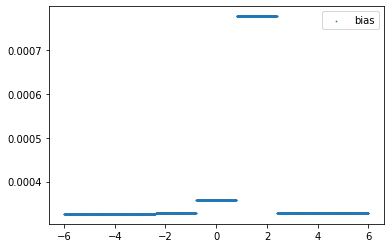

In [84]:
predictions, bias = bias_wrapped_classifier(np.sort(x_val))
plt.scatter(np.sort(x_val), bias, label='bias', s=0.5)
plt.legend()

## 1.3 Aleatoric Estimation
Now, let's do the same thing but for aleatoric estimation! The method we use here is Mean and Variance Estimation (MVE) since we're trying to estimate both mean and variance for every input. As presented in lecture 5, we measure the accuracy of these predictions negative likelihood loss in addition to mean squared error. However, capsa *automatically* does this for us, so we only have to specify the loss function that we want to use for evaluating the predictions, not the uncertainty.

In [73]:
standard_classifier = create_standard_classifier()
mve_wrapped_classifier = MVEWrapper(standard_classifier)


In [74]:
mve_wrapped_classifier.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
  loss=tf.keras.losses.MeanSquaredError(),
)

history = mve_wrapped_classifier.fit(x, y, epochs=20)

Epoch 1/20


640/640 [==============================] - 2s 2ms/step - mve_compiled_loss: 3.0572 - mve_wrapper_loss: 2.7209
Epoch 2/20
640/640 [==============================] - 1s 2ms/step - mve_compiled_loss: 0.4334 - mve_wrapper_loss: -0.0698
Epoch 3/20
640/640 [==============================] - 1s 2ms/step - mve_compiled_loss: 0.2709 - mve_wrapper_loss: -0.5435
Epoch 4/20
640/640 [==============================] - 1s 2ms/step - mve_compiled_loss: 0.2306 - mve_wrapper_loss: -0.7052
Epoch 5/20
640/640 [==============================] - 1s 2ms/step - mve_compiled_loss: 0.2176 - mve_wrapper_loss: -0.7758
Epoch 6/20
640/640 [==============================] - 1s 2ms/step - mve_compiled_loss: 0.2207 - mve_wrapper_loss: -0.8008
Epoch 7/20
640/640 [==============================] - 1s 2ms/step - mve_compiled_loss: 0.2144 - mve_wrapper_loss: -0.8256
Epoch 8/20
640/640 [==============================] - 1s 2ms/step - mve_compiled_loss: 0.2138 - mve_wrapper_loss: -0.8392
Epoch 9/20
640/640 [================

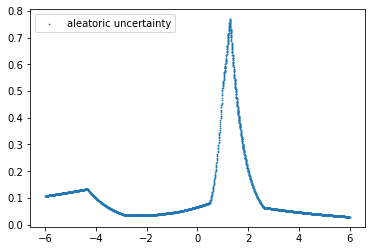

In [75]:
outputs = mve_wrapped_classifier(x_val)
plt.scatter(x_val, outputs.aleatoric, label='aleatoric uncertainty', s=0.5)
plt.legend()

We can see that in the areas of high label noise-- where small changes in the input lead to large changes in the output-- aleatoric uncertainty spikes!

## 1.4 Epistemic Estimation
Finally, let's do the same thing but for epistemic estimation! In this example, we'll use ensembles, which essentially copy the model `N` times and average predictions across all runs for a more robust prediction, and also calculate the variance of the `N` runs. Feel free to play around with any of the epistemic methods shown in the github repository! Which methods perform the best? Why do you think this is?

In [69]:
standard_classifier = create_standard_classifier()
ensemble_wrapper = EnsembleWrapper(standard_classifier, num_members=5)

ensemble_wrapper.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
  loss=tf.keras.losses.MeanSquaredError(),
)

history = ensemble_wrapper.fit(x, y, epochs=10)

Epoch 1/10
640/640 [==============================] - 4s 2ms/step - usermodel_0_compiled_loss: 1.6454 - usermodel_1_compiled_loss: 2.6045 - usermodel_2_compiled_loss: 3.0015 - usermodel_3_compiled_loss: 1.7006 - usermodel_4_compiled_loss: 1.6586
Epoch 2/10
640/640 [==============================] - 2s 3ms/step - usermodel_0_compiled_loss: 0.7776 - usermodel_1_compiled_loss: 1.9006 - usermodel_2_compiled_loss: 1.1599 - usermodel_3_compiled_loss: 0.7811 - usermodel_4_compiled_loss: 0.7477
Epoch 3/10
640/640 [==============================] - 2s 3ms/step - usermodel_0_compiled_loss: 0.5860 - usermodel_1_compiled_loss: 1.5385 - usermodel_2_compiled_loss: 0.8302 - usermodel_3_compiled_loss: 0.5935 - usermodel_4_compiled_loss: 0.5665
Epoch 4/10
640/640 [==============================] - 2s 3ms/step - usermodel_0_compiled_loss: 0.4865 - usermodel_1_compiled_loss: 1.2884 - usermodel_2_compiled_loss: 0.6706 - usermodel_3_compiled_loss: 0.4995 - usermodel_4_compiled_loss: 0.4706
Epoch 5/10
640/6

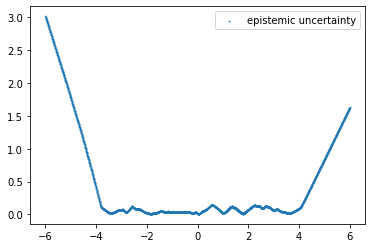

In [71]:
outputs = ensemble_wrapper(x_val)
plt.scatter(x_val, outputs.epistemic, label='epistemic uncertainty', s=0.5)
plt.legend()

## Conclusion
As expected, areas where there is no training data have very high epistemic uncertainty, since all of the testing data is OOD. If our training data contained more samples from this region, would you expect the epistemic uncertainty to decrease?


You've just analyzed the bias, aleatoric uncertainty, and epistemic uncertainty for your first risk-aware model! This is a task that data scientists do constantly to determine methods of improving their models and datasets. In the next part, you'll continue to build off of these concepts to *mitigate* these risks, in addition to diagnosing them!